<h1>Реализация KNN и применение алгоритма для классификации текстов</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import euclidean, cosine
from scipy.spatial.distance import cdist

import pandas as pd

Реализация класса MyKNeighborsClassifier:

In [3]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric 
        self.data = dict()
    
    
    def fit(self, X, y):
        y = np.asarray(y, dtype=np.int8)
        keys = np.unique(y)
            
        for key in keys:
            self.data[key] = X[np.where(y == key)] 
            
    
    def predict(self, X):
        X = np.asarray(X)
        if self.algorithm == 'brute': 
            means = np.zeros((1, X.shape[0]), dtype=np.float32)
            targets = np.array([], dtype=np.int8)
            for target in self.data:
                distances = cdist(X, self.data[target], self.metric)
                indices = np.argpartition(distances, kth=self.n_neighbors, axis=1)[:, :self.n_neighbors]
                distances = np.take_along_axis(distances, indices, axis=1)
                means = np.vstack((means, np.mean(distances, axis=1)[None, ...]))
                targets = np.append(targets, target)
            return targets[np.argmin(means[1:], axis=0)]
            
        elif self.algorithm == 'kd_tree':
            nearest_classes = np.zeros((X.shape[0], 1))
            targets = np.array([], dtype=np.int8)
            for target in self.data:
                tree = KDTree(self.data[target])
                dist, ind = tree.query(X, k=self.n_neighbors)
                nearest_classes = np.hstack((nearest_classes, np.mean(dist, axis=1)[:, np.newaxis]))
                targets = np.append(targets, [target])
            return targets[np.argmin(nearest_classes[:, 1:], axis=1)]
        
        else:
            return None

**IRIS**

Для проверки корректности работы классификатора проверим его на датасете "Ирисы Фишера" из skitir-learn, проверим совпадения ответа с KNN из библиотеки sklearn.

In [59]:
iris = datasets.load_iris()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [61]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [62]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

<b>Скорость</b>

Сравним скорость работы с библиотечным классификатором


In [63]:
%time clf.fit(X_train, y_train)

CPU times: user 1.36 ms, sys: 4 µs, total: 1.36 ms
Wall time: 1.26 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [64]:
%time my_clf.fit(X_train, y_train)

CPU times: user 318 µs, sys: 0 ns, total: 318 µs
Wall time: 280 µs


In [65]:
%time clf.predict(X_test)

CPU times: user 2.56 ms, sys: 0 ns, total: 2.56 ms
Wall time: 3.39 ms


array([0, 2, 1, 1, 1, 0, 0, 2, 0, 2, 1, 2, 1, 2, 0])

In [66]:
%time my_clf.predict(X_test)

CPU times: user 998 µs, sys: 0 ns, total: 998 µs
Wall time: 1.59 ms


array([0, 2, 1, 1, 1, 0, 0, 2, 0, 2, 1, 2, 1, 2, 0], dtype=int8)

###### KD Tree

Добавим реализацию алгоритма kd_tree, проверим точность и сравним время работы с библиотечным классификатором.

In [67]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [68]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [69]:
%time clf.fit(X_train, y_train)

CPU times: user 675 µs, sys: 1.01 ms, total: 1.68 ms
Wall time: 3.41 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [70]:
%time my_clf.fit(X_train, y_train)

CPU times: user 209 µs, sys: 2 µs, total: 211 µs
Wall time: 217 µs


In [71]:
%time clf.predict(X_test)

CPU times: user 3.32 ms, sys: 3 µs, total: 3.32 ms
Wall time: 5.84 ms


array([1, 2, 2, 1, 0, 2, 0, 2, 1, 2, 1, 0, 1, 0, 0])

In [72]:
%time my_clf.predict(X_test)

CPU times: user 1.83 ms, sys: 0 ns, total: 1.83 ms
Wall time: 2.28 ms


array([1, 2, 2, 1, 0, 2, 0, 2, 1, 2, 1, 0, 1, 0, 0], dtype=int8)

In [73]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)

In [74]:
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Классификация текста**

Рассмотрим новый датасет 20 newsgroups

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

data = newsgroups['data']
target = newsgroups['target']

Преобразуем текстовые данные из data с помощью CountVectorizer, ограничим словарь по частотности.

Будем брать только 1000 лучших признаков, а также введем пороги для векторизации.

In [10]:
cur_max_features=1000
best_max_df=0.9
best_min_df=0

In [5]:
vectorizer = CountVectorizer(max_features=cur_max_features, max_df=best_max_df, min_df=best_min_df) 
features = vectorizer.fit_transform(data).toarray()
features.shape

(11314, 1000)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуем разбиение выборки для кросс-валидации на 3 фолдах.

In [5]:
def fold_splits(data, n_splits=3):
    kf = KFold(n_splits)
    return kf.split(data)

Напишем функцию, позволяющую найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Также построим график зависимости средней точности от количества соседей. Для начала можно рассмотреть число соседей от 1 до 10.

In [6]:
def get_best_neighbors(data, target, l=1, r=30, metric='euclidean'):
    n_scores = np.array([])
    for n_neighbors in range(l, r + 1):
        n_scores = np.append(n_scores, get_score(data, target, n_neighbors, metric))
    return n_scores


def get_score(data, target, n_neighbors, cur_metric):
    scores = np.array([])
    for train_index, test_index in fold_splits(data):
        clf = MyKNeighborsClassifier(n_neighbors, algorithm='brute', metric=cur_metric)
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]
        clf.fit(X_train, y_train)
        predict = clf.predict(X_test)
        scores = np.append(scores, accuracy_score(y_test, predict, normalize=True))
    return np.mean(scores)

Нормализация

In [80]:
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
features = features.astype(np.float32)

In [81]:
l_bord = 1
r_bord = 10
n_neighbors = np.arange(l_bord, r_bord + 1)
n_scores = get_best_neighbors(features, target, l_bord, r_bord)

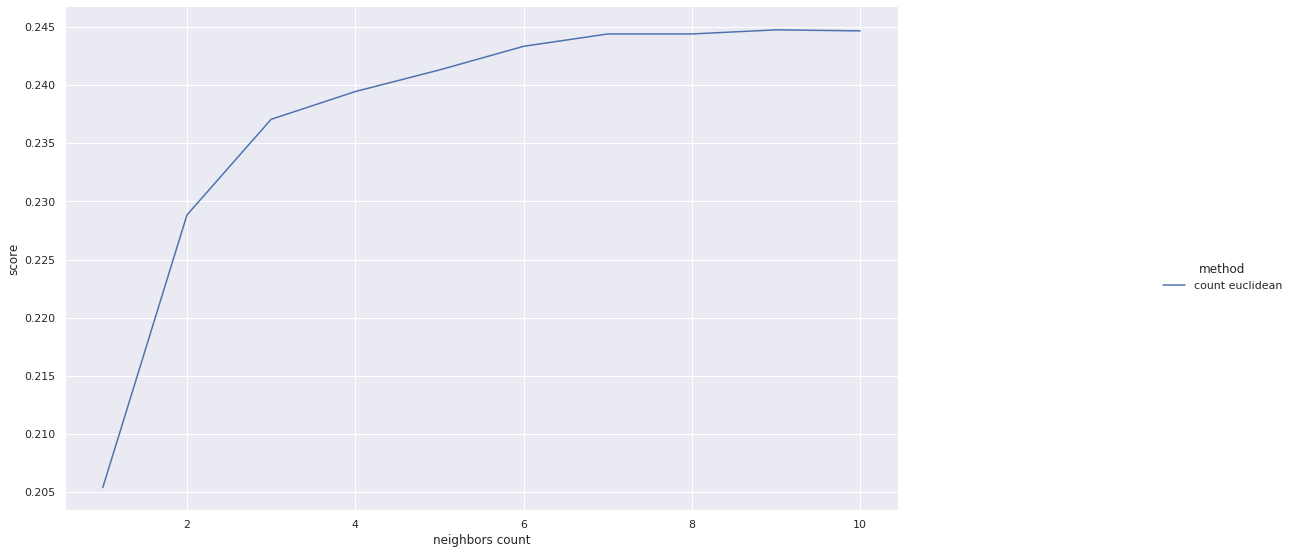

In [82]:
df_count = pd.DataFrame({
    'method' : 'count euclidean',
    'neighbors count' : np.arange(l_bord, r_bord + 1),
    'score' : n_scores}
)

sns.set_theme()
g = sns.relplot(data=df_count, x="neighbors count", y="score", kind='line', hue='method')
g.fig.set_size_inches(20, 8)

Посмотрим, как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию

Сравним модель и выберем лучшую.

In [11]:
cn_vectorizer = CountVectorizer(max_features=cur_max_features, max_df=best_max_df, min_df=best_min_df) 
cn_features = cn_vectorizer.fit_transform(data).toarray()

tf_vectorizer = TfidfVectorizer(max_features=cur_max_features, max_df=best_max_df, min_df=best_min_df)
tf_features = tf_vectorizer.fit_transform(data).toarray()

In [12]:
cn_scaler = StandardScaler()
cn_scaler.fit(cn_features)
cn_features = cn_scaler.transform(cn_features)
cn_features = cn_features.astype(np.float32)

tf_scaler = StandardScaler()
tf_scaler.fit(tf_features)
tf_features = tf_scaler.transform(tf_features)
tf_features = tf_features.astype(np.float32)

In [21]:
l_bord = 40
r_bord = 60
n_neighbors = np.arange(l_bord, r_bord + 1)

cn_euc_n_scores = get_best_neighbors(cn_features, target, l_bord, r_bord, metric='euclidean')
cn_cos_n_scores = get_best_neighbors(cn_features, target, l_bord, r_bord, metric='cosine')
tf_euc_n_scores = get_best_neighbors(tf_features, target, l_bord, r_bord, metric='euclidean')
tf_cos_n_scores = get_best_neighbors(tf_features, target, l_bord, r_bord, metric='cosine')

       neighbors count   n_scores
count        84.000000  84.000000
mean         50.000000   0.288780
std           6.091669   0.161561
min          40.000000   0.106241
25%          45.000000   0.144690
50%          50.000000   0.258928
75%          55.000000   0.391440
max          60.000000   0.528814


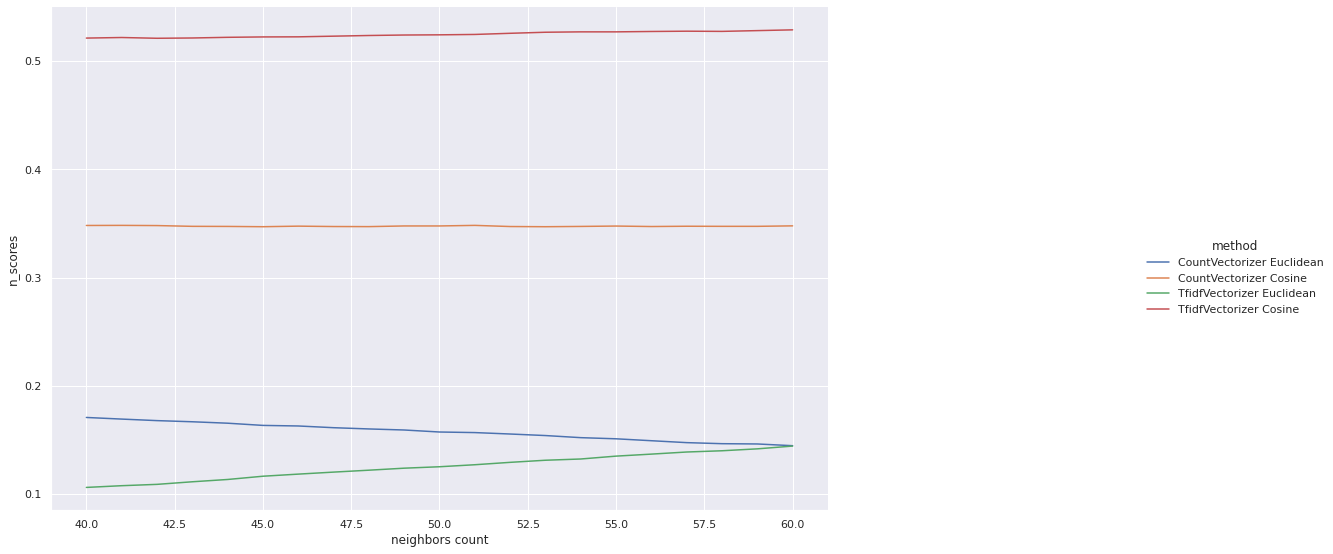

In [30]:
cmp_df = pd.concat(
    [
      pd.DataFrame({'neighbors count' : np.arange(l_bord, r_bord + 1), 'n_scores' : cn_euc_n_scores, 'method' : 'CountVectorizer Euclidean'}),
      pd.DataFrame({'neighbors count' : np.arange(l_bord, r_bord + 1), 'n_scores' : cn_cos_n_scores, 'method' : 'CountVectorizer Cosine'}),
      pd.DataFrame({'neighbors count' : np.arange(l_bord, r_bord + 1), 'n_scores' : tf_euc_n_scores, 'method' : 'TfidfVectorizer Euclidean'}),
      pd.DataFrame({'neighbors count' : np.arange(l_bord, r_bord + 1), 'n_scores' : tf_cos_n_scores, 'method' : 'TfidfVectorizer Cosine'}),
    ]
)

print(cmp_df.describe())

sns.set_theme()
g = sns.relplot(data=cmp_df, x="neighbors count", y="n_scores", kind='line', hue='method')
g.fig.set_size_inches(20, 8)

Мы рассмотрели число соседей от 40 до 60, что является наиболее показательным промежутком(опытным путем проверено, что увеличение этого параматра с единицы приводит к резкому увеличению точности, и с некоторого момента точность меняется более стабильно) для сравнения методов. Также мы выбрали 1000 самых главных признаков. Поменяем немного эти параметры.

Обозначим лучшие параметры для нашей модели. Опытным путем путем выявлено, что 70 соседей дает хороший результат за разумное время(это можно предположить и из графика), лучшие метрика и векторизация очевидны из графика выше. Ограничения max_df и min_df также подобраны опытным путем и показывают наилучшую точность. Число признаков 10000, тк это уже достаточно много, при этом на них можно получить результат до рассвета. 

In [13]:
best_n_neighbors = 70
best_metric = 'cosine'
best_vectorizer = TfidfVectorizer
best_n_features = 10000
best_max_df=0.9
best_min_df=0

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [16]:
vect = best_vectorizer(max_features=best_n_features, max_df=best_max_df, min_df=best_min_df)

In [17]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
train_data = newsgroups['data']
train_target = newsgroups['target']

newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
test_data = newsgroups['data']
test_target = newsgroups['target']

Создадим общий словарь токенов, содержащихся в документах двух выборок. Всегда можем так сделать, так как используем только информацию об объектах, таргет мы не трогаем. 

In [18]:
vect.fit(train_data + test_data)
train_features = vect.transform(train_data).toarray()
test_features = vect.transform(test_data).toarray()

In [19]:
train_scaler = StandardScaler()
train_scaler.fit(train_features)
train_features = train_scaler.transform(train_features)
train_features = train_features.astype(np.float32)

test_scaler = StandardScaler()
test_scaler.fit(test_features)
test_features = test_scaler.transform(test_features)
test_features = test_features.astype(np.float32)

In [36]:
clf = MyKNeighborsClassifier(n_neighbors=best_n_neighbors, algorithm='brute', metric=best_metric)
clf.fit(train_features, train_target)

In [37]:
predict = clf.predict(test_features)
accuracy_score(predict, test_target)

0.6498937865108869

Сравним с точностью на кросс-валидации:

In [21]:
get_score(train_features, train_target, best_n_neighbors, best_metric)

0.7006367031087558

Качество на тестовой выборке отличается в худшую сторону, т.к. даже несмотря на кросс-валидацию, переобучение всегда присутствует, и на "незнакомых" данных алгоритм показывает худший результат. Тем не менее, точность на тестовой выборке падает не критически сильно, поэтому можно сказать, что данная модель оказалась относительно устойчива к переобучению(как минимум в рамках данного датасета).